In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer

import time
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import gc

In [67]:
#importing training and testing jsons
debug = False
train_df = pd.read_json('train.json').set_index('id')
test_df = pd.read_json('test.json').set_index('id')
if debug is True:
    train_df = train_df.sample(100)
    test_df = test_df.sample(100) 
traindex = train_df.index
testdex = test_df.index  #proper indexing
print("Training Data Shape: ",train_df.shape)
print("Testing Data Shape: ", test_df.shape) #printing the shape of each dataset
y = train_df.cuisine.copy()

#Combining data for pre-processing
df = pd.concat([train_df.drop("cuisine", axis=1), test_df], axis=0)
df_index = df.index
print("All Data Shape: ", df.shape)
del test_df; gc.collect();

df.head()



Training Data Shape:  (39774, 2)
Testing Data Shape:  (1, 1)
All Data Shape:  (39775, 1)


,ingredients
id,
10259,"[romaine lettuce, black olives, grape tomatoes..."
25693,"[plain flour, ground pepper, salt, tomatoes, g..."
20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
22213,"[water, vegetable oil, wheat, salt]"
13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [68]:
#Ingredients are so important in for deciding cuisine type i split each ingredient into 
#its own variable, so the machine knows which ingredients are present
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(tokenizer=lambda x: [i.strip() for i in x.split(',')], lowercase=False)
dummies = vect.fit_transform(df['ingredients'].apply(','.join)) 


df = pd.DataFrame(dummies.todense(),columns=vect.get_feature_names())
print("Vocab Length: ", len(vect.get_feature_names()))
print("All Data Shape: ", df.shape)
df.index= df_index

print("Number of Predictors: ", df.shape[0])


Vocab Length:  6725
All Data Shape:  (39775, 6725)
Number of Predictors:  39775


In [69]:
#splitting the data back into train and test
X = df.loc[traindex,:]
print("Number of Cuisine Types: ", y.nunique())
print("X Shape: ", X.shape)
test_df = df.loc[testdex,:]
print("Test DF Shape: ", test_df.shape)
del df; gc.collect();

Number of Cuisine Types:  20
X Shape:  (39774, 6725)
Test DF Shape:  (1, 6725)


In [70]:
#modelling uaing logisticregression
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [71]:
#calculating accuracy of predictions
model = LogisticRegression(multi_class= 'ovr')
score = cross_validate(model, X, y, return_train_score=False)
score["test_score"].mean()

0.7759346344549897

In [72]:
#pretty test id with predicted cuisine types + saving to a csv
model.fit(X,y)
final = model.predict(test_df)
final_df = pd.Series(final, index=testdex).rename('cuisine')
final_df.to_csv("completed_test.csv", index=True, header=True)
print(final_df.head())

id
88009    mexican
Name: cuisine, dtype: object


In [8]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [9]:
color_theme = dict(color = ['rgba(221,160,221,1)','rgba(169,169,169,1)','rgba(255,160,122,1)','rgba(176,224,230,1)','rgba(169,169,169,1)','rgba(255,160,122,1)','rgba(176,224,230,1)',
                   'rgba(188,143,143,1)','rgba(221,160,221,1)','rgba(169,169,169,1)','rgba(255,160,122,1)','rgba(176,224,230,1)','rgba(189,183,107,1)','rgba(188,143,143,1)','rgba(221,160,221,1)','rgba(169,169,169,1)','rgba(255,160,122,1)','rgba(176,224,230,1)','rgba(169,169,169,1)','rgba(255,160,122,1)'])
temp = train_df['cuisine'].value_counts()
trace = go.Bar(y=temp.index[::-1],x=(temp / temp.sum() * 100)[::-1],orientation = 'h',marker=color_theme)
layout = go.Layout(title = "Top cuisine with recipe count (%)",xaxis=dict(title='Recipe count',tickfont=dict(size=14,)),
                   yaxis=dict(title='Cuisine',titlefont=dict(size=16),tickfont=dict(size=14)),margin=dict(l=200,))
data = [trace]
fig = go.Figure(data=data, layout=layout)
iplot(fig,filename='basic-bar')
temp = pd.DataFrame(temp)
temp.head()

,cuisine
italian,7838
mexican,6438
southern_us,4320
indian,3003
chinese,2673


In [10]:
labels = temp.index.tolist()
values = (temp["cuisine"]/temp["cuisine"].sum())*100

trace = go.Pie(labels=labels, values=values,hole = 0.4)

iplot([trace], filename='basic_pie_chart')

Text(0.5,1,'Ingredients in a Dish Distribution')

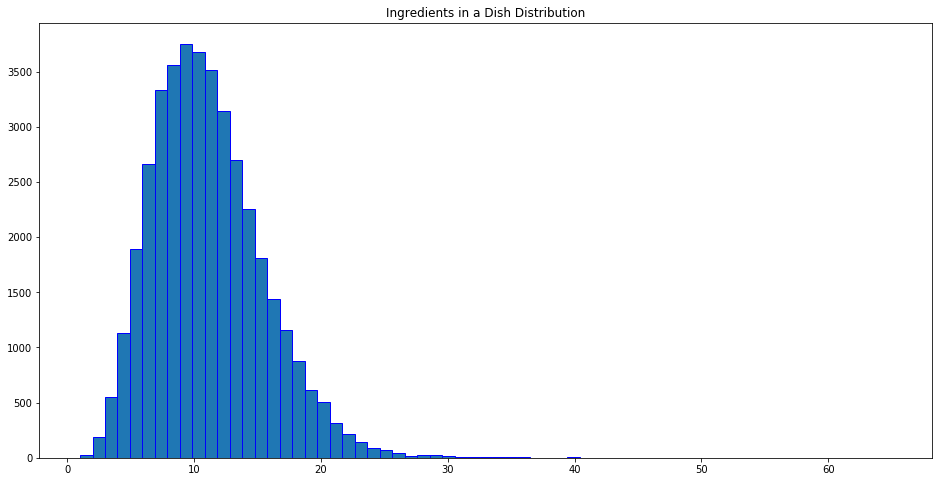

In [11]:
plt.hist(train_df['ingredients'].str.len(),bins=max(train_df['ingredients'].str.len()),edgecolor='b')
plt.gcf().set_size_inches(16,8)
plt.title('Ingredients in a Dish Distribution')

In [12]:
import nltk
from collections import Counter


In [13]:
newtraindf = train_df
newtraindf['seperated_ingredients'] = train_df['ingredients'].apply(','.join)

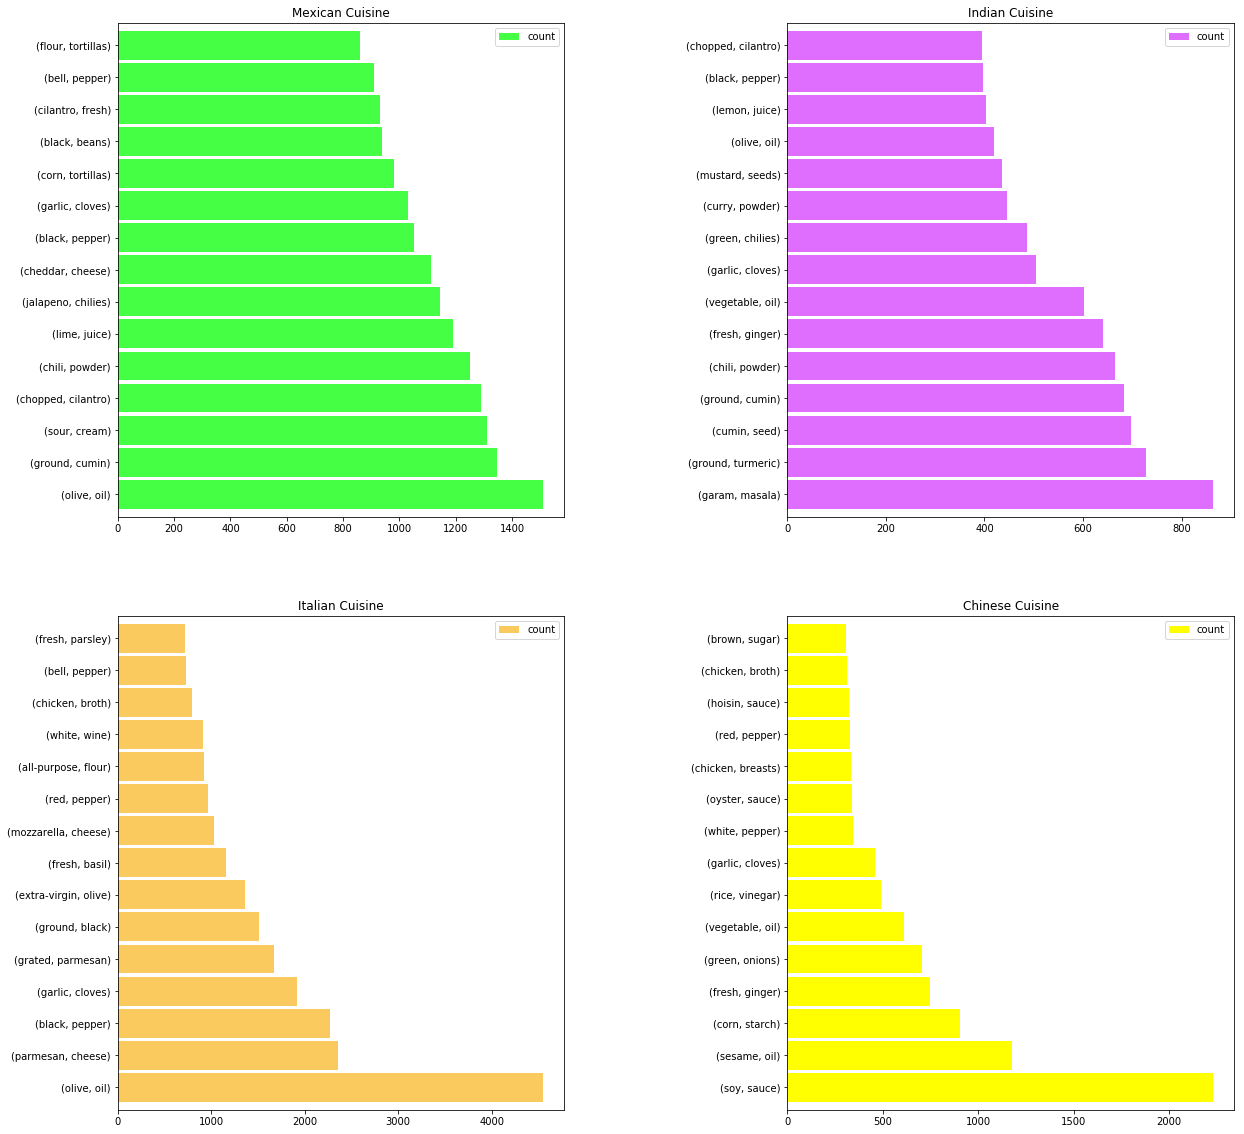

In [14]:
newtraindf['for ngrams']=newtraindf['seperated_ingredients'].str.replace(',',' ')
f,ax=plt.subplots(2,2,figsize=(20,20))
def ingre_cusine(cuisine):
    frame=train_df[newtraindf['cuisine']==cuisine]
    common=list(nltk.bigrams(nltk.word_tokenize(" ".join(frame['for ngrams']))))
    return pd.DataFrame(Counter(common),index=['count']).T.sort_values('count',ascending=False)[:15]
ingre_cusine('mexican').plot.barh(ax=ax[0,0],width=0.9,color='#45ff45')
ax[0,0].set_title('Mexican Cuisine')
ingre_cusine('indian').plot.barh(ax=ax[0,1],width=0.9,color='#df6dfd')
ax[0,1].set_title('Indian Cuisine')
ingre_cusine('italian').plot.barh(ax=ax[1,0],width=0.9,color='#fbca5f')
ax[1,0].set_title('Italian Cuisine')
ingre_cusine('chinese').plot.barh(ax=ax[1,1],width=0.9,color='#ffff00')
ax[1,1].set_title('Chinese Cuisine')
plt.subplots_adjust(wspace=0.5)